# Are ICSD Compounds Missing from OQMD in Predictions?
The OQMD is missing many compounds from the ICSD. Here, we are testing wehther these missing compounds are "found" by our Deep Learning model.

In [1]:
%matplotlib inline
from matminer.featurizers.composition import ElementFraction
from sklearn.neighbors import NearestNeighbors
from pymatgen import Composition
from pymatgen.util.string import latexify
import os
import pandas as pd
from multiprocessing import Pool
from matplotlib import pyplot as plt
import numpy as np

Make useful tools

In [2]:
ef_gen = ElementFraction()

## Load in the missing ICSD compounds from the OQMD
Find which ICSD compounds are missing from the OQMD. These were generated by parsing the composition out of all ICSD cifs (available on Wolverton group clusters)

In [3]:
with open('compositions.list') as fp:
    compositions = set([Composition(x) for x in fp])
print('Read in %d unique ICSD compositions'%len(compositions))

Read in 90831 unique ICSD compositions


Get all of the elements in the OQMD

In [4]:
with open('oqmd_elements.list') as fp:
    oqmd_elements = [x.strip() for x in fp.readlines()]

Get entries with only OQMD elements

In [5]:
def has_only_oqmd_elements(composition):
    return len(set([x.symbol for x in composition.keys()]).difference(oqmd_elements)) == 0
assert not has_only_oqmd_elements(Composition('Am'))
assert not has_only_oqmd_elements(Composition('AmO'))
assert has_only_oqmd_elements(Composition('NaCl'))

In [6]:
compositions = np.array([x for x in compositions if has_only_oqmd_elements(x)])
print('%d of these compositions have only OQMD elements'%len(compositions))

90648 of these compositions have only OQMD elements


Build a NN lookup tool. 

Note: It would be more efficient to build this array for the other, larger datasets. But, building a KDTree for 1M entries is prohibitive on my system.

In [7]:
%%time
icsd_nn = NearestNeighbors(n_neighbors=1, n_jobs=-1).fit(
    [ef_gen.featurize(x) for x in compositions]
)

CPU times: user 17.7 s, sys: 82.1 ms, total: 17.8 s
Wall time: 17.7 s


## Load the Datasets
We need both the training set and predictions

### DL Predictions
These data files contain the compositions that are predicted to be stable

In [8]:
%%time
def load_DL_predictions(path):
    """Loads in the predictions from Dipendra, and renames the `delta_e` column to match the `oqmd_data`
    
    Also generates a `PDEntry` for each composition, and computes which system this entry is in
    """
    output = pd.read_csv(path, sep=' ')
    output.rename(columns={'delta_e_predicted': 'delta_e'}, inplace=True)
    output['comp_obj'] = output['composition'].apply(lambda x: Composition(x))
    return output
dl_predictions = dict([(x, load_DL_predictions(os.path.join('new-datasets', '%s_stable-0.2.data.gz'%x)))
     for x in ['binary', 'ternary', 'quaternary']
     ])

CPU times: user 8min 56s, sys: 3.73 s, total: 9min
Wall time: 9min


### OQMD Training Set
Get the near-stable compositions in the training set

In [9]:
oqmd_data = pd.read_csv('oqmd_all.txt', delim_whitespace=True).query('delta_e > -20')

/home/wardlt/software/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Get the non-crazy compositions.

In [10]:
oqmd_data['stability'] = pd.to_numeric(oqmd_data['stability'], errors='coerce')

In [11]:
oqmd_data.query('delta_e < 1', inplace=True)
print('Loaded %d training entries'%len(oqmd_data))

Loaded 476399 training entries


## Question 1: Which ICSD compositions are not in the training set?

Find the nearest composition to many of these 

In [12]:
%%time
icsd_dist, icsd_ind = icsd_nn.kneighbors([ef_gen.featurize(Composition(x)) for x in oqmd_data['comp']])

CPU times: user 2h 41min 33s, sys: 515 ms, total: 2h 41min 34s
Wall time: 22min 29s


Plot a histogram

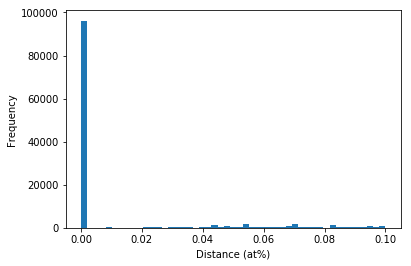

In [13]:
fig, ax = plt.subplots()

ax.hist(icsd_dist, np.linspace(0, 0.1))

ax.set_xlabel('Distance (at%)')
ax.set_ylabel('Frequency')

_Finding_: 0.01 seems reasonable. 

In [14]:
match_cutoff = 0.01

In [15]:
oqmd_matched = sum(icsd_dist < match_cutoff)
print('%d/%d (%.1f%%) OQMD entries match an ICSD entry'%(oqmd_matched, len(oqmd_data),
                                                               float(oqmd_matched)/len(oqmd_data)*100))

96720/476399 (20.3%) OQMD entries match an ICSD entry


In [16]:
icsd_matched = len(set(icsd_ind[icsd_dist<match_cutoff]))
print('%d/%d (%.1f%%) ICSD entries match an OQMD entry'%(icsd_matched, len(compositions),
                                                             float(icsd_matched)/len(compositions)*100))

28364/90648 (31.3%) ICSD entries match an OQMD entry


Eliminate ICSD compositions that were matched to the OQMD

In [17]:
not_matched = set(range(len(compositions))).difference(set(icsd_ind[icsd_dist<match_cutoff]))
print('%d ICSD compositions are not found in the OQMD'%len(not_matched))

62284 ICSD compositions are not found in the OQMD


In [18]:
icsd_not_oqmd_compositions = compositions[list(not_matched)]

In [19]:
with open(os.path.join('icsd-search', 'icsd-not-matched.list'), 'w') as fp:
    for c in icsd_not_oqmd_compositions:
        print(latexify(c.get_integer_formula_and_factor()[0]), file=fp)

/home/wardlt/software/pymatgen/pymatgen/core/periodic_table.py:398: UserWarning: No electronegativity for Ar. Setting to infinity. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)
/home/wardlt/software/pymatgen/pymatgen/core/periodic_table.py:398: UserWarning: No electronegativity for He. Setting to infinity. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)
/home/wardlt/software/pymatgen/pymatgen/core/periodic_table.py:398: UserWarning: No electronegativity for Ne. Setting to infinity. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)


Make a new distance computer

In [20]:
icsd_not_oqmd_nn = NearestNeighbors(n_neighbors=1, n_jobs=-1).fit(
    [ef_gen.featurize(x) for x in compositions[list(not_matched)]]
)

## Match DL Predictions to ICSD Compounds
Here, the goal is to find which ICSD compositions match up to at least one DL predictions

In [21]:
def match_compositions(predictions):
    """Find which ICSD compositions match a DL prediction"""
    
    icsd_dist, icsd_inn = icsd_not_oqmd_nn.kneighbors([ef_gen.featurize(x) for x in predictions['comp_obj']])
    icsd_matches = set(icsd_inn[icsd_dist<match_cutoff])
    return icsd_matches

In [22]:
%%time
dl_matches = dict([(k,match_compositions(dl_predictions[k])) for k in dl_predictions.keys()])

CPU times: user 5d 8h 45min 33s, sys: 9.82 s, total: 5d 8h 45min 42s
Wall time: 13h 23min 46s


In [23]:
for k,v in dl_matches.items():
    print('Found %d %s ICSD compounds in DL predictions'%(len(v), k))
    with open(os.path.join('icsd-search', 'dl-found_%s.list'%k), 'w') as fp:
        print('matched_composition', file=fp)
        for x in icsd_not_oqmd_compositions[list(v)]:
            print(latexify(x.get_integer_formula_and_factor()[0]), file=fp)

Found 27 binary ICSD compounds in DL predictions
Found 183 ternary ICSD compounds in DL predictions
Found 144 quaternary ICSD compounds in DL predictions


/home/wardlt/software/pymatgen/pymatgen/core/periodic_table.py:398: UserWarning: No electronegativity for Ar. Setting to infinity. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)
